In [1]:
# some of the packages are not installed or up-to-date on colab. Therefore, we need to force colab to install some libs used 
# in this project
import os
os.system('pip install pip --upgrade') # update pip
os.system('pip install pretrainedmodels') # to use torch pretrained models'collection: e.g., resnet, densenet,....
os.system('pip install -U albumentations --no-binary qudida,albumentations') # albumentations lib for image augmentations
os.system('pip install -U git+https://github.com/rwightman/pytorch-image-models.git') # also many pretrained image models under torch
os.system('pip install pytorch-ignite')
os.system('pip install efficientnet_pytorch') # efficient net models from pytorch

0

In [2]:
# Importing libraries

import numpy as np
import pandas as pd 
import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# pytorch libs
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

# pretrained models: these are collections for pretrained models under pytorch
import pretrainedmodels
import torchvision.models
import timm

# Sklearn libs
import sklearn
from   sklearn.model_selection import train_test_split, StratifiedKFold
from   sklearn.preprocessing  import LabelEncoder

import cv2
import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class DatasetCfg():
  def __init__(self, root = '/content/drive/MyDrive/'):
    self.root = root
  def get_train_df(self):
    return pd.read_csv(os.path.join(self.root,'diabetic_retina/train.csv'))
  def get_image_path(self):
    return os.path.join(self.root,'diabetic_retina/train_images/')
  def get_model_path(self):
    return os.path.join(self.root, 'Colab Notebooks/P3_Identify_Diabetic_Retina/P3_saved_models/DiabeticResNet18')
  def get_modules_path(self): 
    return os.path.join(self.root, 'Colab Notebooks/P3_Identify_Diabetic_Retina')
    
dataset_cfg = DatasetCfg()

In [5]:
import sys  
sys.path.insert(0, dataset_cfg.get_modules_path())
%load_ext autoreload
%autoreload 2

from MyModels import DiabeticEfficientNet
from MyModels import DiabeticResNet
from MyModels import DiabeticEnsembleEfficientNets
import MyModels
from Config import Config
import utils
from dataIterator import DiabeticIterator
import MyPreprocessing
import training
import losses
import optimizers
import dataLoader

In [6]:
x = !nvidia-smi
utils.check_GPU(x)

Sun Mar  6 04:44:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# loading data
# Reading the csv file
data_df = dataset_cfg.get_train_df()
print(data_df.shape)

(3662, 2)


In [7]:
MyPreprocessing.check_nan_cols(data_df)

Features with null values = []


In [8]:
images_path = dataset_cfg.get_image_path() 
data_df = MyPreprocessing.create_img_path('id_code',data_df,images_path)

## **Data Visualization**

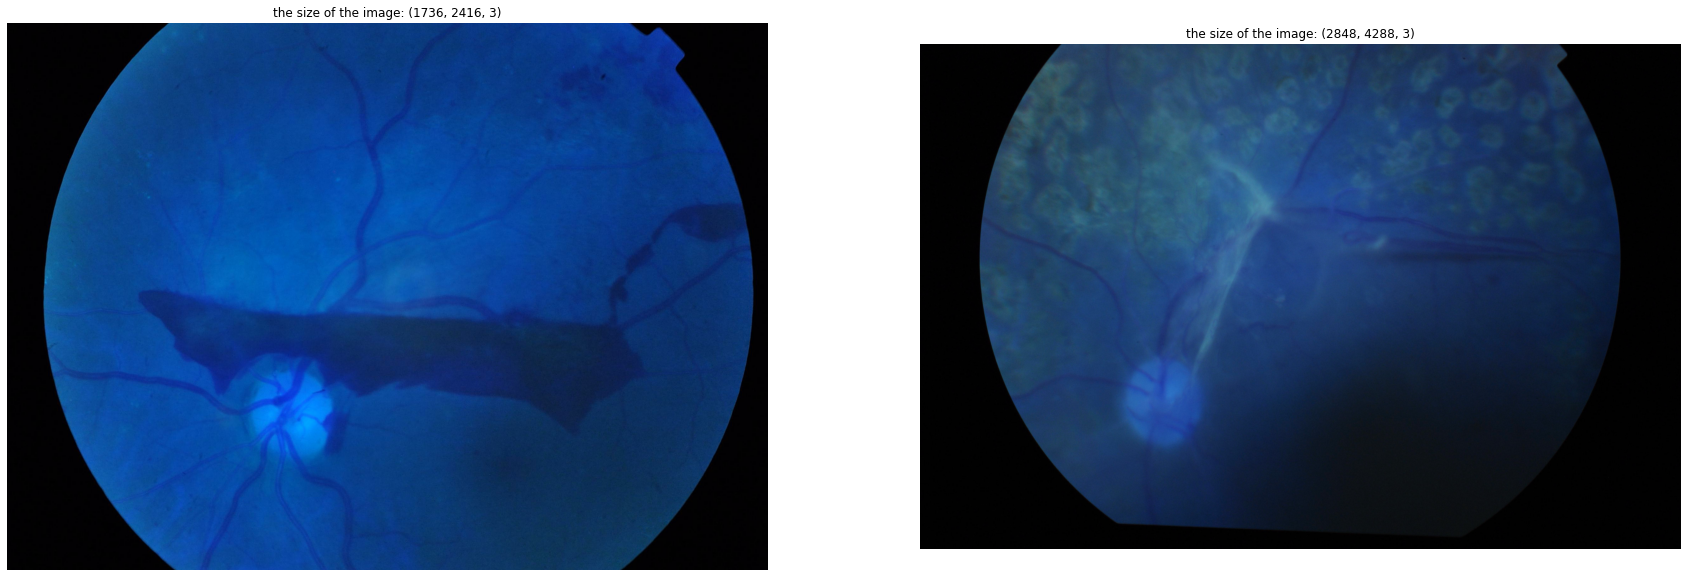

In [31]:
# pick up k different diagnosis groups. in each diagnosis group, pick up m images randomly and plot them together
utils.plot_rand_images(data_df,'id_code','diagnosis',k=1,m=2)



# Splitting Data

In [9]:
# separate some data as test
train,test = train_test_split(data_df, shuffle=True, test_size=0.1,random_state=42)

In [10]:
# separate some data as validation
kf = StratifiedKFold(n_splits=Config.K_FOLDS, shuffle=True, random_state=42)
train_inds = []
val_inds = []

for train_idx, val_idx in kf.split(train, train['diagnosis']):
  train_inds.append(train_idx)
  val_inds.append(val_idx)

# Imaged augmentation, dataiterating, dataloading, training

In [23]:
test_meta_table=test.reset_index(drop=True)
train_losses_kfolds=[]
validation_losses_kfolds=[]
kfolds_models=[]

for i in range(1): #Config.K_FOLDS
  train_meta_table = data_df.loc[train_inds[i]].reset_index(drop=True)
  val_meta_table = data_df.loc[val_inds[i]].reset_index(drop=True)

  # defining augmentations for images on train dataset, valid dataset and test dataset 
  train_transform,valid_transform,test_transform = dataLoader.img_augmentation()
  # Building iterator and instantiating dataloader
  train_dataloader,valid_dataloader,test_dataloader = dataLoader.MyDataloader(train_meta_table,train_transform,val_meta_table,valid_transform,test_meta_table,test_transform)
  # using transfer learning
  model1 = MyModels.DiabeticDenseNet('densenet121', drop_classifier=True)
  model2 = MyModels.DiabeticDenseNet('densenet161', drop_classifier=True)
  DiabeticModel = MyModels.DiabeticEnsembleDenseNets(model1,model2,Config.N_CLASSES)
  optimizer, scheduler = optimizers.def_optimize(DiabeticModel)

  DiabeticModel.to(Config.DEVICE)
  model_path = dataset_cfg.get_model_path() + f'_{i}.pth'
  train_losses, validation_losses = training.train_epochs(model = DiabeticModel,optimizer=optimizer, scheduler=scheduler,train_dataloader=train_dataloader,valid_dataloader=valid_dataloader,epochs=15, model_path=model_path)

  del DiabeticModel
  torch.cuda.empty_cache()

  train_losses_kfolds.append(train_losses)
  validation_losses_kfolds.append(validation_losses)


length of train_iterator = 2636
length of valid_iterator = 659
length of test_iterator = 367


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

........ epoch 0


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 0, mean  train_loss: 0.8274043765736789, mean val_loss 0.6604636836619604
........ epoch 1


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 1, mean  train_loss: 0.6295244399367309, mean val_loss 0.6143996708449864
........ epoch 2


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 2, mean  train_loss: 0.5924179641211905, mean val_loss 0.6036480849697476
........ epoch 3


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 3, mean  train_loss: 0.5441196897044415, mean val_loss 0.6134418845176697
........ epoch 4


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 4, mean  train_loss: 0.491497471746875, mean val_loss 0.6053157732600257
........ epoch 5


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 5, mean  train_loss: 0.44424353121984295, mean val_loss 0.6466234695343744
........ epoch 6


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 6, mean  train_loss: 0.4436731721933295, mean val_loss 0.6342287404196603
........ epoch 7


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 7, mean  train_loss: 0.3943534010975826, mean val_loss 0.6449511278243292
........ epoch 8


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 8, mean  train_loss: 0.37196865959501846, mean val_loss 0.6688580754257384
........ epoch 9


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 9, mean  train_loss: 0.36940098690187056, mean val_loss 0.7027881415117354
........ epoch 10


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 10, mean  train_loss: 0.3154044523835182, mean val_loss 0.735237446569261
........ epoch 11


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 11, mean  train_loss: 0.2850258936424081, mean val_loss 0.7055841145061311
........ epoch 12


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 12, mean  train_loss: 0.27875686754904144, mean val_loss 0.7973853803816295
........ epoch 13


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 13, mean  train_loss: 0.24116267713649972, mean val_loss 0.7907864316588357
........ epoch 14


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

For current epoch 14, mean  train_loss: 0.22850414156550314, mean val_loss 0.8026602154686338


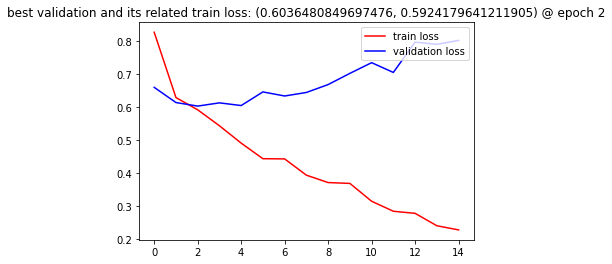

In [25]:
index = validation_losses.index(min(validation_losses))
plt.plot(train_losses,'-r',label='train loss')
plt.plot(validation_losses,'-b',label='validation loss')
plt.legend(loc="upper right")
plt.title(f'best validation and its related train loss: ({min(validation_losses)}, {train_losses[index]}) @ epoch {index}')
plt.show()

In [ ]:
plt.plot(train_losses_kfolds[4],'-r',label='train losses for kfolds')
plt.plot(validation_losses_kfolds[4],'-b',label='val losses for kfolds')
plt.legend(loc='upper right')
plt.show()

# Model Inference

In [ ]:
# loading a saved model
ItemMatchModel = ItemMatchEfficientNet('b0', Config.N_CLASSES)
ItemMatchModel.to(Config.DEVICE)
model_path = dataset_cfg.get_model_path() + f'_{0}.pth'
ItemMatchModel.load_state_dict(torch.load(model_path,map_location=torch.device(Config.DEVICE)))

<All keys matched successfully>

In [ ]:
y_preds = []
y_trues = []
for step,(x_,y_) in enumerate(test_dataloader):

    if step%5==0:print(step,end=' ')
    x_ = x_.to(Config.DEVICE)
    y_ = y_.to(Config.DEVICE)

    with torch.no_grad():
        y_pred = ItemMatchModel(x_)
        y_pred = torch.nn.functional.softmax(y_pred,dim=1).detach().to('cpu').numpy()
        y_pred = np.argmax(y_pred,axis=1)
        y_true = y_.detach().to('cpu').numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_true)

. . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
(np.array(y_preds)==np.array(y_trues)).mean()

0.15766423357664233

3143


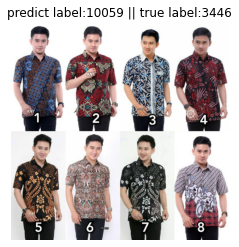

----------------------------------------------------------------------------------------------------
214


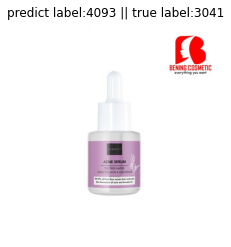

----------------------------------------------------------------------------------------------------


In [ ]:
import random
for i in random.sample(list(test_meta_table.index), 2): # pick 2 samples to test
    print(i)
    raw_image = cv2.imread(test_meta_table.loc[i,'image'])
    label = test_meta_table.loc[i,'target']
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    
    img_aug = test_transform(image=raw_image)  # for future unseen data
    transformed_img = img_aug['image']
    # make this single image 4-D tensor!!
    transformed_img = transformed_img.reshape(1,transformed_img.shape[0],transformed_img.shape[1],transformed_img.shape[2])
    y_pred = ItemMatchModel(transformed_img.to(Config.DEVICE))
    y_pred = torch.nn.functional.softmax(y_pred,dim=1).detach().to('cpu').numpy()
    y_pred = np.argmax(y_pred,axis=1)[0]
    plt.imshow(raw_image)
    plt.title('predict label:{} || true label:{}'.format(y_pred,label))
    plt.axis('off')
    plt.show()
    print('-'*100)

In [ ]:
y_pred_kfolds=[]
y_true_kfolds=[]
for i in range(5): 
  # loading a saved model
  ItemMatchModel = ItemMatchEfficientNet('b0', Config.N_CLASSES)
  ItemMatchModel.to(Config.DEVICE)
  model_path = dataset_cfg.get_model_path() + f'_{i}.pth'
  ItemMatchModel.load_state_dict(torch.load(model_path,map_location=torch.device(Config.DEVICE)))

  y_preds = []
  y_trues = []
  for step,(x_,y_) in enumerate(test_dataloader):
      if step%5==0:print(step,end=' ')
      x_ = x_.to(Config.DEVICE)
      y_ = y_.to(Config.DEVICE)

      with torch.no_grad():
          y_pred = ItemMatchModel(x_)
          y_pred = torch.nn.functional.softmax(y_pred,dim=1).detach().to('cpu').numpy()
          y_pred = np.argmax(y_pred,axis=1)
          y_true = y_.detach().to('cpu').numpy()
          y_preds.extend(y_pred)
          y_trues.extend(y_true)

  print('')
  y_pred_kfolds.append(y_preds)
  y_true_kfolds.append(y_trues)


0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 
0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 
0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 
0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 
0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 
